In [88]:
import numpy as np

from jax import numpy as jp

from jax import jit,grad
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

from Algorithms import *

from Lattice import honeycomb

import pickle as pkl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
def h(r,c,l):
    return c * jp.exp(-(r**2) / l**2)

# The differentiable kernel function with parameters c,l not filled.

def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return h(jp.linalg.norm(x1-x2+small_sig,axis = -1),c,l)

In [90]:
def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,jp.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*jp.log(jp.linalg.det(np.eye(len(KA))+KA/var_0))
    else:
        return 1/2*jp.log(jp.linalg.det(KA))

# Experiment parameters

In [110]:
T = 19

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radius = 1
step_size = 1

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T
R[0,0] = 0

N = len(ref)

x0 = search_region_center

# Callables

In [92]:

x_objective = jit(lambda z: GPMI(z,c=c,l=l,var_0=var_0))

kernel = partial(k,c=c,l=l)


# Different algorithms, call as needed.

In [93]:
rand_u,_,_,_ = rand_u_search(x0,\
                         search_region_radius,x_objective,T,step_size)

rand_u_x = x0+np.cumsum(np.vstack([np.zeros(rand_u.shape[-1]),rand_u]),axis=0)

In [94]:
proj_u = projected_u_gradient(x_objective,x0,[rand_u],ref,R,step_size) # Replace rand_u with any other initializations.

0th start outof 1.


In [95]:
rand_x,_,_,_ = rand_search(x0,search_region_radius,x_objective,T,step_size)

In [96]:
proj_x = projected_x_gradient(x_objective,[rand_x],ref,R,T,step_size) # Replace rand_x with any other initializations.

0th start outof 1.


In [97]:
greedy = incremental_greedy(kernel,x0,step_size,ref,search_region_radius,T,var_0,c)

In [98]:
N_layer = int(np.ceil(np.sqrt((T-1)/6)))+1

hive=honeycomb(np.min([search_region_radius,(N_layer-1)*step_size]),N_layer)

In [99]:
thetas = np.linspace(0,2*np.pi,T+1)[:-1]
equi_angle = search_region_center.reshape(-1,1)+search_region_radius*np.array([np.cos(thetas),np.sin(thetas)])
equi_angle = np.vstack([equi_angle.T])

# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [113]:

d = h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*np.array(h(R,c=c,l=l))
b[0,0] = h(0,c=c,l=l) # Initial location constraint.

In [129]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [S>=h(2*search_region_radius,c,l)]

constraints += [B>=1*b]



prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

In [130]:
upper_bound

41.99077922957981

In [131]:
h(2*search_region_radius,c,l)

DeviceArray(0.01831564, dtype=float32)

In [132]:
S.value

array([[1.00001807, 0.36787963, 0.36422426, 0.36347305, 0.36327144,
        0.36321732, 0.3632028 , 0.3631989 , 0.36319785, 0.36319757,
        0.36319749, 0.36319747, 0.36319747, 0.36319746, 0.36319746,
        0.36319745, 0.36319741, 0.36320855, 0.36321918],
       [0.36787963, 1.00000044, 0.36787963, 0.1958068 , 0.14962952,
        0.13723563, 0.1339086 , 0.13301533, 0.13277546, 0.13271104,
        0.13269373, 0.13268907, 0.13268782, 0.13268746, 0.13268727,
        0.13268688, 0.13268552, 0.1326846 , 0.13268166],
       [0.36422426, 0.36787963, 1.00000044, 0.36787963, 0.19558403,
        0.14934681, 0.13693672, 0.1336053 , 0.13271084, 0.13247065,
        0.13240613, 0.1323888 , 0.13238414, 0.13238285, 0.1323824 ,
        0.13238188, 0.13238025, 0.13237838, 0.13237415],
       [0.36347305, 0.1958068 , 0.36787963, 1.00000044, 0.36787963,
        0.19558519, 0.14934833, 0.13693832, 0.13360693, 0.13271248,
        0.13247228, 0.13240777, 0.13239043, 0.13238574, 0.13238436,
        0.132

In [136]:
gr = incremental_greedy(kernel,x0,step_size,ref,1,T,var_0,c)
Gram(kernel,greedy)

DeviceArray([[1.00000000e+00, 3.67880136e-01, 1.38251722e-01,
              5.83957136e-03, 2.58805492e-04, 1.27519859e-04,
              1.47861382e-03, 1.46291641e-04, 7.24083977e-03,
              1.59313349e-04, 1.41243590e-03, 1.48753490e-04,
              6.31688582e-03, 1.24820464e-04, 1.15057197e-03,
              3.29330638e-02, 7.31620472e-04, 2.44786078e-03,
              1.34416681e-04],
             [3.67880136e-01, 1.00000000e+00, 3.67939919e-01,
              1.13721624e-01, 4.84612212e-03, 5.18561108e-04,
              8.47728690e-04, 1.27944568e-05, 3.15273530e-04,
              9.72089765e-07, 5.39377925e-06, 1.52710896e-07,
              2.68328495e-05, 1.78782130e-07, 8.44258193e-06,
              1.75097527e-03, 5.31302103e-05, 1.29310228e-03,
              4.72627406e-04],
             [1.38251722e-01, 3.67939919e-01, 1.00000000e+00,
              3.67943734e-01, 1.15799971e-01, 4.58049402e-02,
              5.12624718e-02, 1.55855692e-03, 5.94381336e-03,
        

In [102]:
sols = {
        'Honey Comb':[hive,'orange',1,'o'],
        'Equi-angle':[equi_angle,'green',1,'o'],
        'Random Search': [rand_x,'grey',0.3,'x'],
#         'Random u Search': [rand_u_x,'grey',0.3,'x'],
        'Projected x gradient': [proj_x,'blue',1,'o'],
        'Projected u gradient': [proj_u,'red',1,'o'],
        'Incremental greedy':[greedy,'purple',1,'o']
       }

In [103]:
with open('GrandComparisonR-{}-T-{}.pkl'.format(search_region_radius,T),'wb') as file:
    pkl.dump(sols,file)

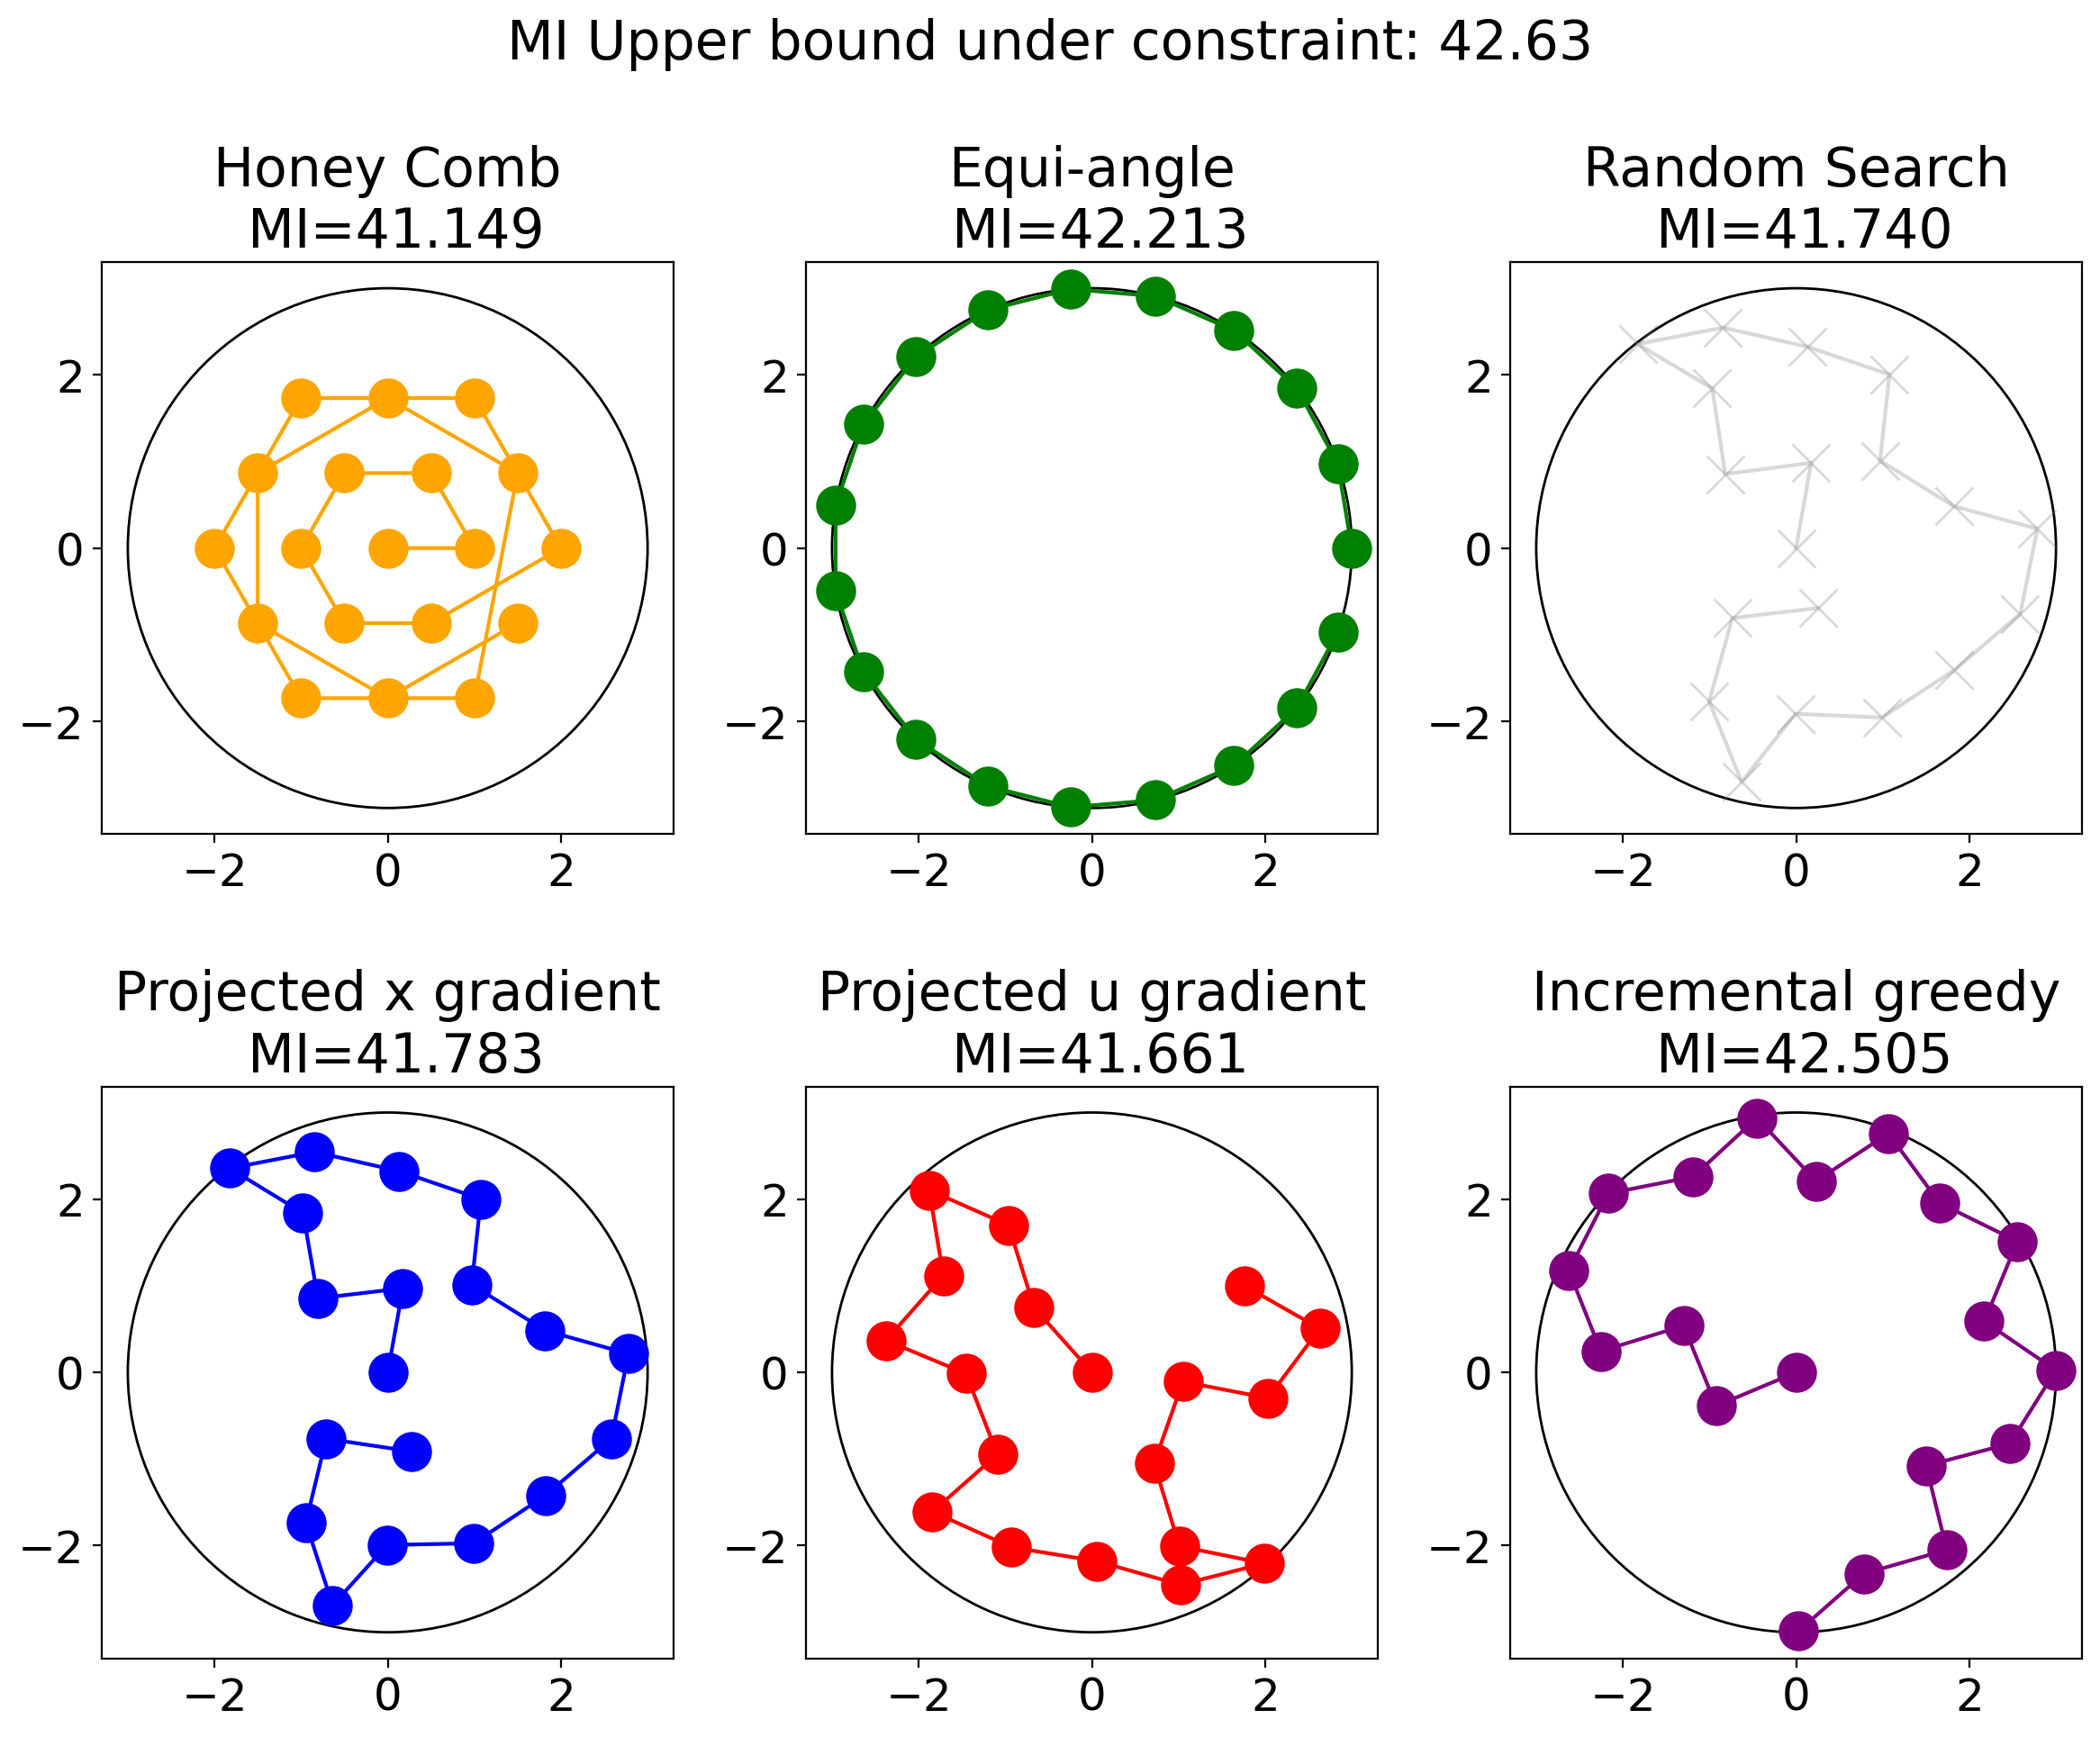

In [104]:
plt.rc('font',size=18)
fig,axes = plt.subplots(2,3,dpi=200,figsize=(12,10))

axes = axes.flatten()

for m,(key,val) in enumerate(sols.items()):
    ax = axes[m]
 
    ax.plot(val[0][:,0],val[0][:,1],marker = val[3],markersize = 15,\
             alpha = val[2],
            color = val[1],)
    
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("{}\n MI={:.3f}".format(key,x_objective(val[0])))
    
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.suptitle('MI Upper bound under constraint: {:.2f}'.format(upper_bound))

plt.tight_layout()
plt.show()